In [106]:
# Modules installed with the following
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import cv2


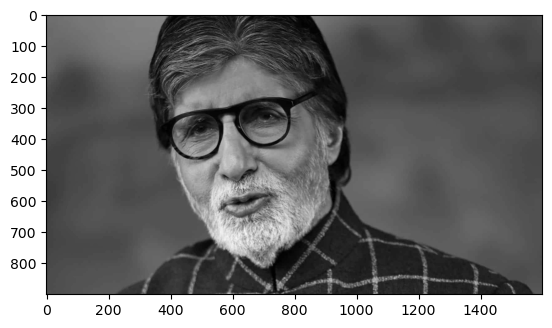

In [107]:
# Read and plot and convert to gray image with following
img = cv2.imread('./test image/Amitabh Bachchan.jpg')
img.shape
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape
plt.imshow(gray, cmap='gray')



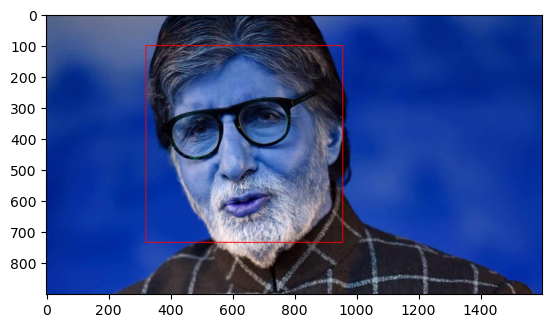

In [108]:
# Face detection
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces
(x,y,w,h) = faces[0]
x,y,w,h
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

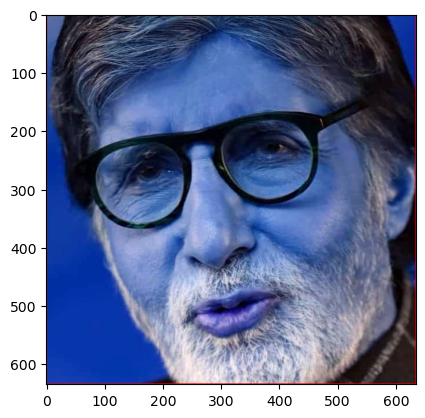

In [109]:

    roi_color = face_img[y:y+h, x:x+w]
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [110]:
# Following function will be run on all images to detect and crop face
def cropped_image_for_2_eyes(imagepath):
    image = cv2.imread(imagepath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = image[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

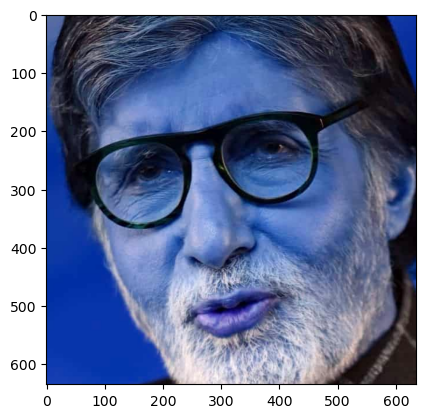

In [111]:
croppedimage = cropped_image_for_2_eyes('./test image/Amitabh bachchan.jpg')
plt.imshow(croppedimage)

In [112]:
# Now all images inside dataset folder will cropped and created in cropped folder inside dataset
pathdata = "./dataset/"
pathcrdata = "./dataset/cropped/"
import os
imgdirectory = []
for entry in os.scandir(pathdata):
    if entry.is_dir():
        imgdirectory.append(entry.path)

In [113]:
import shutil
if os.path.exists(pathcrdata):
     shutil.rmtree(pathcrdata)
os.mkdir(pathcrdata)
croppedimagedir = []
celebrityfilenames = {}
for img_dir in imgdirectory:
    count = 1
    celebrityname = img_dir.split('/')[-1]
    celebrityfilenames[celebrityname] = []
    for entry in os.scandir(img_dir):
        roi_color = cropped_image_for_2_eyes(entry.path)
        if roi_color is not None:
            croppedfolder = pathcrdata + celebrityname
            if not os.path.exists(croppedfolder):
                os.makedirs(croppedfolder)
                croppedimagedir.append(croppedfolder)
                print("Generating cropped images in folder: ",croppedfolder)
            croppedfilename = celebrityname + str(count) + ".png"
            croppedfilepath = croppedfolder + "/" + croppedfilename
            cv2.imwrite(croppedfilepath, roi_color)
            celebrityfilenames[celebrityname].append(croppedfilepath)
            count += 1

Generating cropped images in folder:  ./dataset/cropped/Amitabh Bachchan
Generating cropped images in folder:  ./dataset/cropped/Dwayne Johnson
Generating cropped images in folder:  ./dataset/cropped/Harry Styles
Generating cropped images in folder:  ./dataset/cropped/Kylie Jenner
Generating cropped images in folder:  ./dataset/cropped/Leonardo DiCaprio
Generating cropped images in folder:  ./dataset/cropped/Rihanna
Generating cropped images in folder:  ./dataset/cropped/Steve Harvey


In [114]:
# Manually delete cropped images if any

In [115]:
# Wavelet transformed imageto extract features from a cropped image
#  Below is shown for one image below

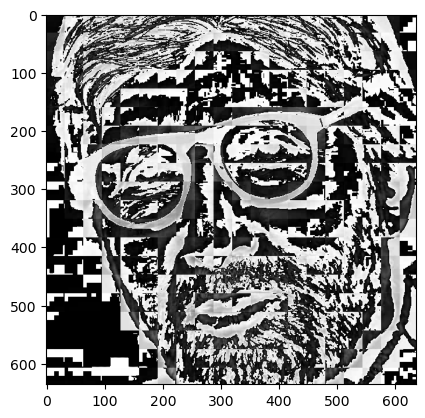

In [116]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H
im_har = w2d(croppedimage,'db1',5)
plt.imshow(im_har, cmap='gray')

In [117]:
classdict = {}
count = 0
for celebrityname in celebrityfilenames.keys():
    classdict[celebrityname] = count
    count = count + 1
classdict

X, y = [], []
for celebrityname, trainingfiles in celebrityfilenames.items():
    for trainingimage in trainingfiles:
        img = cv2.imread(trainingimage)
        if img is None:
            continue
        scalledrawimg = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalledimghar = cv2.resize(img_har, (32, 32))
        combinedimg = np.vstack((scalledrawimg.reshape(32*32*3,1),scalledimghar.reshape(32*32,1)))
        X.append(combinedimg)
        y.append(classdict[celebrityname])
    

In [118]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(123, 4096)

In [119]:
# Now model will be trained using diferent learning models to find best model

In [120]:
# Support vector machine with rbf kernel tuned with heuristic finetuning

In [121]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', MinMaxScaler()), ('svc', SVC(kernel = 'rbf', C = 9))])
pipe.fit(Xtrain, ytrain)
pipe.score(Xtest, ytest)

0.6774193548387096

In [122]:
# 67% accuracy is achieved without the use of nuetral network!

In [123]:
# Images tested 
len(Xtest)

31

In [124]:
print(classification_report(ytest, pipe.predict(Xtest)))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.67      0.33      0.44         6
           2       1.00      0.50      0.67         4
           3       0.50      1.00      0.67         2
           4       0.57      1.00      0.73         8
           5       0.86      0.86      0.86         7
           6       0.00      0.00      0.00         3

    accuracy                           0.68        31
   macro avg       0.66      0.67      0.62        31
weighted avg       0.66      0.68      0.63        31



C:\Users\tashf\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tashf\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tashf\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [125]:
# GridSearch to find best model with difeerent parameters

In [126]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}
scores = []
bestestimator = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(MinMaxScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(Xtrain, ytrain)
    scores.append({
        'model': algo,
        'bestscore': clf.best_score_,
        'bestparameters': clf.best_params_
    })
    bestestimator[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','bestscore','bestparameters'])
df

model  bestscore  \
0                  svm   0.651462   
1        random_forest   0.511696   
2  logistic_regression   0.619298   

                                 bestparameters  
0        {'svc__C': 1, 'svc__kernel': 'linear'}  
1  {'randomforestclassifier__n_estimators': 10}  
2                  {'logisticregression__C': 1}

In [127]:
bestestimator

{'svm': Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [128]:
bestestimator['svm'].score(Xtest,ytest)




0.7096774193548387

In [129]:
bestestimator['random_forest'].score(Xtest,ytest)

0.5483870967741935

In [130]:
bestestimator['logistic_regression'].score(Xtest,ytest)

0.6451612903225806

In [131]:
# SVM gives best accuracy score on X/Ytest and X/Ytrain

In [132]:
bestclassifier = bestestimator['svm']
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, bestclassifier.predict(Xtest))
cm

array([[1, 0, 0, 0, 0, 0, 0],
       [1, 2, 0, 0, 1, 2, 0],
       [0, 1, 2, 0, 1, 0, 0],
       [0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 8, 0, 0],
       [0, 0, 0, 0, 1, 6, 0],
       [0, 1, 0, 0, 1, 0, 1]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

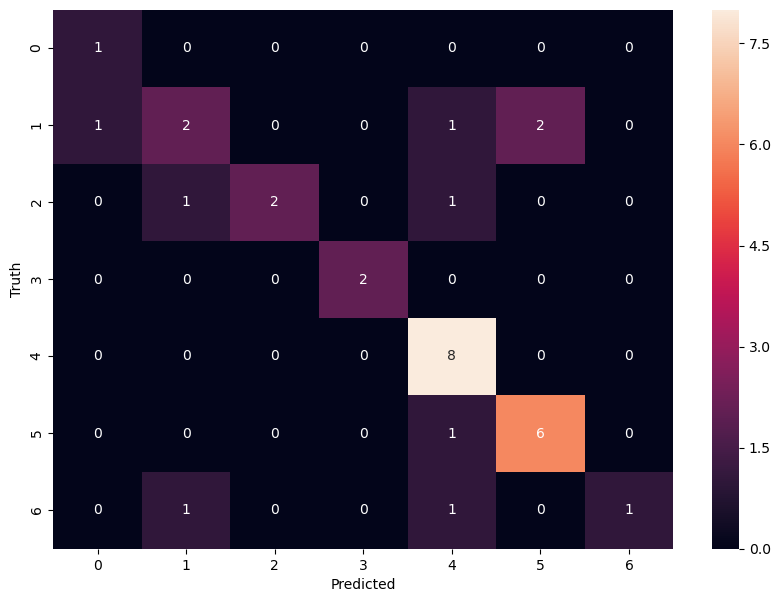

In [133]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [134]:
# Saving Model and classdictionary

In [135]:
!pip install joblib
import joblib 
joblib.dump(bestclassifier, 'savedmodel.pkl') 

['savedmodel.pkl']

In [136]:
import json
with open("classdictionary.json","w") as f:
    f.write(json.dumps(classdict))